## Inspired by Quantum Measurement and Control, this notebook looks to apply concepts presented earlier in the book to further take aways and understandings regarding the concepts.

### What does it mean to make discrete measurements on a Quantum System and how does that varry from Classical measurements?


#### Introduce Codeblock 1

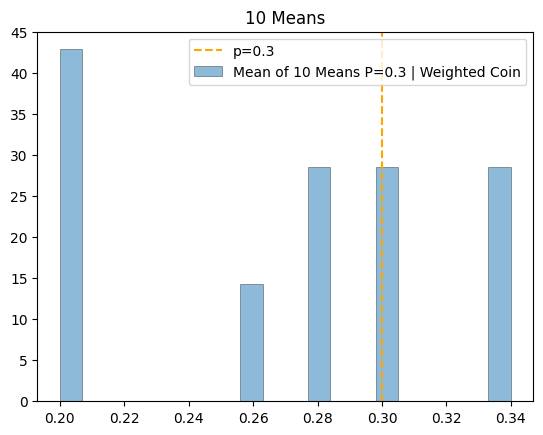

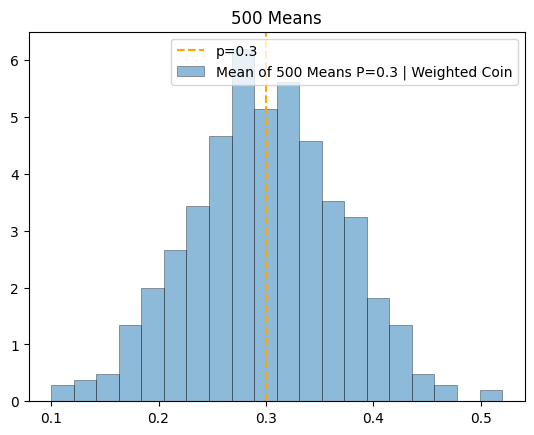

In [66]:
import numpy as np
import matplotlib.pyplot as plt     

#we define a weighted coin to simulate classic events and measuermenst of these classical events
p=0.3
outcomes=[1,0]
prob=[p,1-p]
classicMeans = []
for i in range (500):
    classicSample = np.random.choice(outcomes,size =50,p=prob)
    if (i == 10):
        plt.title("10 Means")
        plt.axvline(0.3, color='orange', linestyle='--',label="p=0.3")
        plt.hist(classicMeans, bins=20, density=True, alpha=0.5,edgecolor = 'black',linewidth = 0.5, label="Mean of 10 Means P=0.3 | Weighted Coin");
        plt.legend()
        plt.show()
    classicMeans.append(np.mean(classicSample))

plt.axvline(0.3, color='orange', linestyle='--',label="p=0.3")
plt.title("500 Means")
plt.hist(classicMeans, bins=20,edgecolor = 'black',linewidth = 0.5, density=True, alpha=0.5, label="Mean of 500 Means P=0.3 | Weighted Coin");
plt.legend();

### Quantum Measurement and Variance 

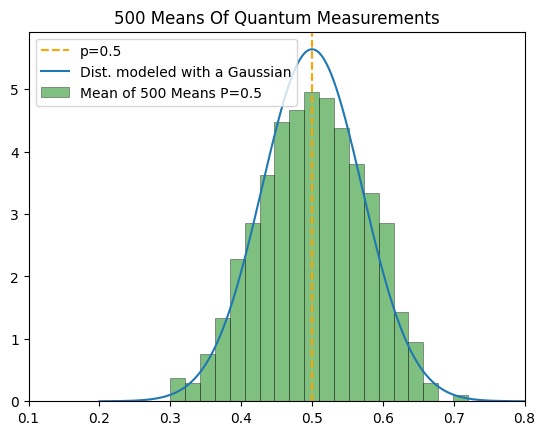

In [49]:
from qiskit import QuantumCircuit as qc
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt     
from qiskit_aer import AerSimulator

from IPython.display import display

sim = AerSimulator()

theta = np.pi/2 # theta = pi/2
quantumMeans = [] 

def curve(samples,p,num):
  mu = p
  sigma = np.sqrt(p*(1-p)/num)
  x = np.linspace(min(samples) - 0.1, max(samples)+0.1, 1000)
  y = (1 / np.sqrt(2*np.pi*sigma**2)) *  np.exp(-0.5 * (x - mu)**2 /sigma**2)
  return x,y

for i in range (500):
    circA = qc(1,1)
    circA.ry(theta,0) # explain this on paper 
    circA.measure(0,0)
    comp = transpile(circA,sim)
    result = sim.run(comp, shots = 50)
    counts = result.result().get_counts()
    
    mean = counts.get('1',0)/50
    quantumMeans.append(mean)
plt.xlim(0.1, 0.8)   
plt.axvline(0.5, color='orange', linestyle='--',label="p=0.5")
plt.title("500 Means Of Quantum Measurements")
x1, y1 = curve(quantumMeans,.5,50)
plt.plot(x1, y1, label="Dist. modeled with a Gaussian")
plt.hist(quantumMeans, bins=20,edgecolor = 'black',linewidth = 0.5, density=True,color = 'green', alpha=0.5, label="Mean of 500 Means P=0.5");
xmin, xmax = plt.xlim()
plt.legend();
plt.show();


### Fixing the p to match the weighted coin 

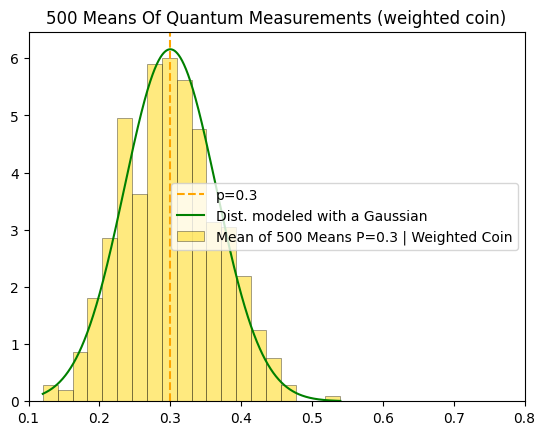

In [44]:
from qiskit import QuantumCircuit as qc
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt     
from qiskit_aer import AerSimulator

from IPython.display import display

sim = AerSimulator()
p = 0.3
theta = 2 * np.arcsin(np.sqrt(p))
quantumMeans = [] 

for i in range (500):
    circA = qc(1,1)
    circA.ry(theta,0) # explain this on paper 
    circA.measure(0,0)
    comp = transpile(circA,sim)
    result = sim.run(comp, shots = 50)
    counts = result.result().get_counts()
    
    mean = counts.get('1',0)/50
    quantumMeans.append(mean)
plt.xlim(0.1, .8)  
plt.axvline(0.3, color='orange', linestyle='--',label="p=0.3")
plt.title("500 Means Of Quantum Measurements (weighted coin)")
x1, y1 = curve(quantumMeans,.3,50)
plt.plot(x1, y1, label="Dist. modeled with a Gaussian", color = 'green')
plt.hist(quantumMeans, bins=20,edgecolor = 'black',linewidth = 0.5, density=True,color = 'gold',  alpha=0.5, label="Mean of 500 Means P=0.3 | Weighted Coin");
plt.legend();


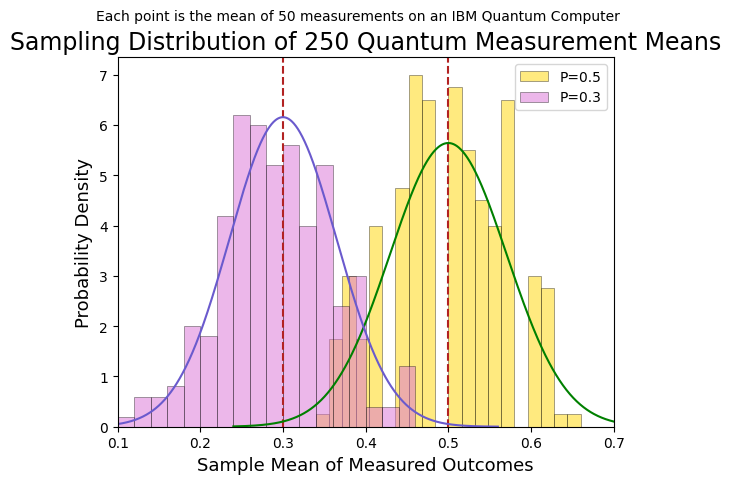

In [58]:
from qiskit import QuantumCircuit as qc
from qiskit import transpile
import numpy as np
import matplotlib.pyplot as plt     
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2


from IPython.display import display

p = 0.3
theta1 = 2 * np.arcsin(np.sqrt(p))
theta2 = np.pi/2

meanCount = 250
shotsPer = 50
totalSamples = meanCount * shotsPer

circA = qc(1, 1)
circB = qc(1, 1)
circA.ry(theta1, 0)
circB.ry(theta2, 0)
circA.measure(0, 0)
circB.measure(0, 0)

# interface with IBM
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

compA = transpile(circA, backend=backend, optimization_level=1)
compB = transpile(circB, backend=backend, optimization_level=1)

sampler = SamplerV2(mode=backend)
job = sampler.run([compA, compB], shots=totalSamples)
result = job.result()

countsA = result[0].data.c.get_counts()
countsB = result[1].data.c.get_counts()

def curve(samples,p,num):
  mu = p
  sigma = np.sqrt(p*(1-p)/num)
  x = np.linspace(min(samples) - 0.1, max(samples)+0.1, 1000)
  y = (1 / np.sqrt(2*np.pi*sigma**2)) *  np.exp(-0.5 * (x - mu)**2 /sigma**2)
  return x,y

def countsToBitlist(counts, total):
    bits = []
    for bitstr, c in counts.items():
        bits.extend([int(bitstr)] * c)
    bits = np.array(bits)
    if len(bits) != total:
        raise ValueError(f"Expected {total} shots, got {len(bits)}")
    np.random.shuffle(bits)  
    return bits

def bitlistToMean(bits, shostPer):
    return [np.mean(bits[i:i+shostPer])
            for i in range(0, len(bits), shostPer)]

bitsA = countsToBitlist(countsA, totalSamples)
bitsB = countsToBitlist(countsB, totalSamples)

quantumMeansW = bitlistToMean(bitsA, shotsPer)  # corresponds to p=0.3
quantumMeansF = bitlistToMean(bitsB, shotsPer)  # corresponds to p=0.5


plt.xlim(0.1, .7)  
plt.axvline(0.3, color='firebrick', linestyle='--')
plt.axvline(0.5, color='firebrick', linestyle='--')
plt.title("Sampling Distribution of 250 Quantum Measurement Means", fontsize=17)
plt.suptitle("Each point is the mean of 50 measurements on an IBM Quantum Computer", fontsize=10)
plt.xlabel("Sample Mean of Measured Outcomes", fontsize=13)
plt.ylabel("Probability Density", fontsize=13)
x1, y1 = curve(quantumMeansF,.5,50)
x2, y2 = curve(quantumMeansW,.3,50)
plt.plot(x1, y1,  color = 'green')
plt.plot(x2, y2, color = 'slateblue')
plt.hist(quantumMeansF, bins=20,edgecolor = 'black',linewidth = 0.5, density=True,color = 'gold',  alpha=0.5, label="P=0.5");
plt.hist(quantumMeansW, bins=20,edgecolor = 'black',linewidth = 0.5, density=True,color = 'orchid',  alpha=0.5, label="P=0.3");
plt.legend();
plt.show();
